In [27]:
###############################################################


#################
# LINEAR MODELS #
#################


# Installs (only needed on first run)
'''
!pip install ripser
!pip install persim
!pip install networkx
!pip install scikit-learn
!pip install matplotlib
!pip install tables
'''


# Package imports (needed every run)
import numpy as np
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
from scipy.spatial.distance import pdist, squareform
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import os # Required to use file paths
import shutil # Required to move temporary files around
import random # Used to create training/testing split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import KFold


# As needed
from google.colab import drive
drive.mount('/content/drive')


# Tell python which folder to look in. Change depending on the bin dimension
dim_bins = 10
folder_path = f"/content/drive/MyDrive/dim_bins{dim_bins}/"
relative_path = f"/dim_bins{dim_bins}/"

# Function to the h5 file at the chosen path
def read_h5(file_path):
    if file_path.endswith(".h5"):
      df = pd.read_hdf(file_path)
      print("File successfully read.\n")
      return df
    else:
      print("File is not an h5. Skipping...\n")

folder_path = f"/content/drive/MyDrive/Glider data/dim_bins{dim_bins}/"

file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

def split_files(file_names, num_training):
    # Randomly select 'num_in_list1' files
    training_split = random.sample(file_names, num_training)
    # The remaining files
    testing_split = [f for f in file_names if f not in training_split]
    return training_split, testing_split

testing_amount = 16
num_training = len(file_names) - testing_amount  # 12 testing files, rest for training + eval
training_split, testing_split = split_files(file_names, num_training)

print("Training Split:", training_split)
print("Testing Split:", testing_split)

training_datasets = [pd.read_hdf(os.path.join(folder_path, f), key="data") for f in training_split]
testing_datasets = [pd.read_hdf(os.path.join(folder_path, f), key="data") for f in testing_split]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Split: ['component_24_binned_245.h5', 'component_7_binned_344.h5', 'component_1_binned_227.h5', 'component_6_binned_180.h5', 'component_25_binned_204.h5', 'component_30_binned_204.h5', 'component_28_binned_194.h5', 'component_31_binned_171.h5', 'component_22_binned_390.h5', 'component_23_binned_198.h5', 'component_9_binned_325.h5', 'component_20_binned_482.h5', 'component_8_binned_254.h5', 'component_21_binned_202.h5', 'component_15_binned_257.h5', 'component_4_binned_257.h5']
Testing Split: ['component_0_binned_349.h5', 'component_2_binned_300.h5', 'component_3_binned_210.h5', 'component_5_binned_229.h5', 'component_10_binned_236.h5', 'component_11_binned_277.h5', 'component_12_binned_340.h5', 'component_14_binned_165.h5', 'component_13_binned_444.h5', 'component_18_binned_209.h5', 'component_17_binned_192.h5', 'component_16_binned_217.h5', 'compone

Created 252 custom CV splits (5 train folds, 5 evaluation folds per split).


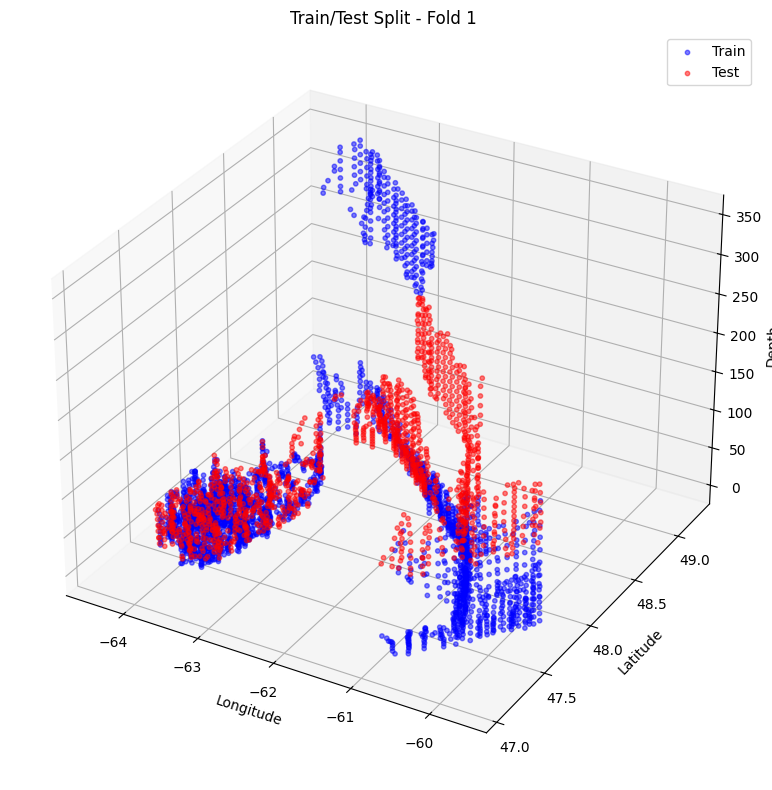

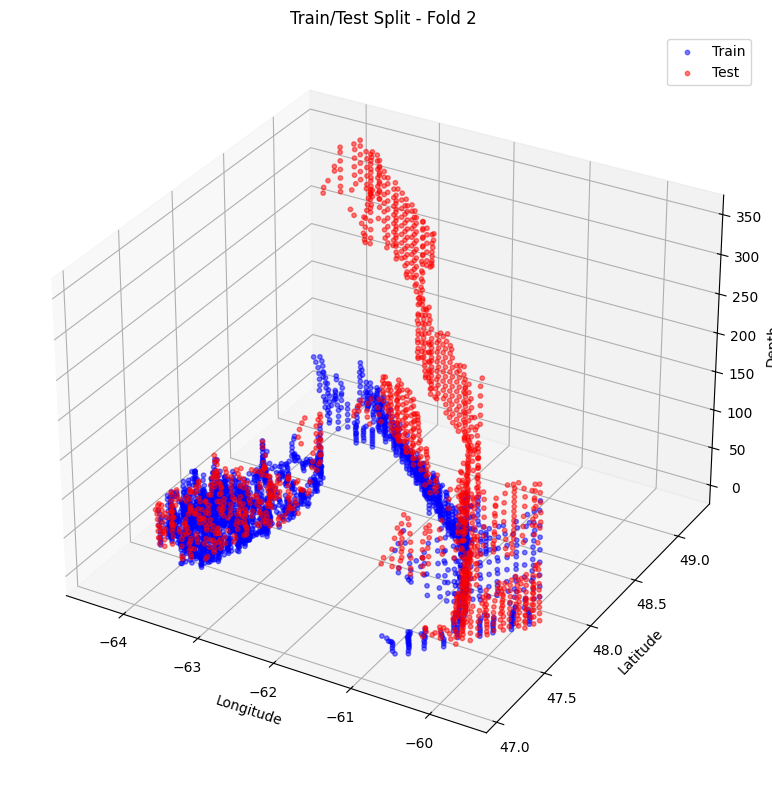

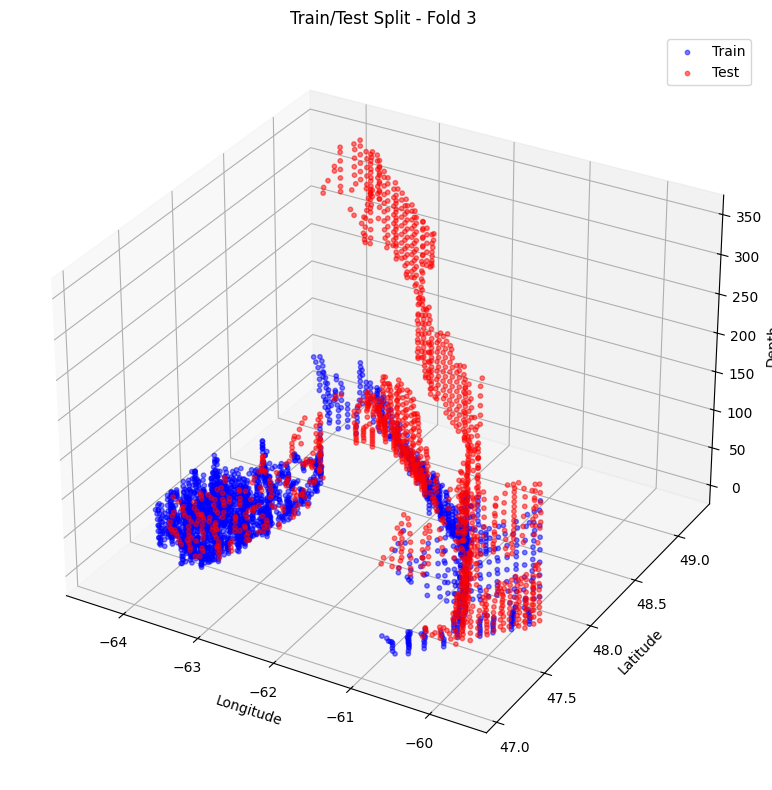

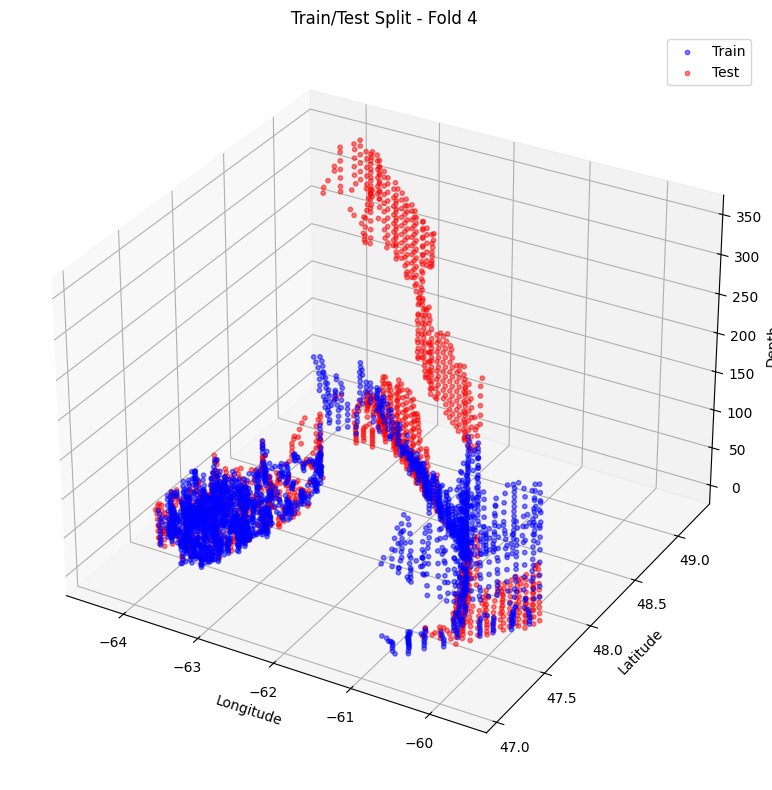

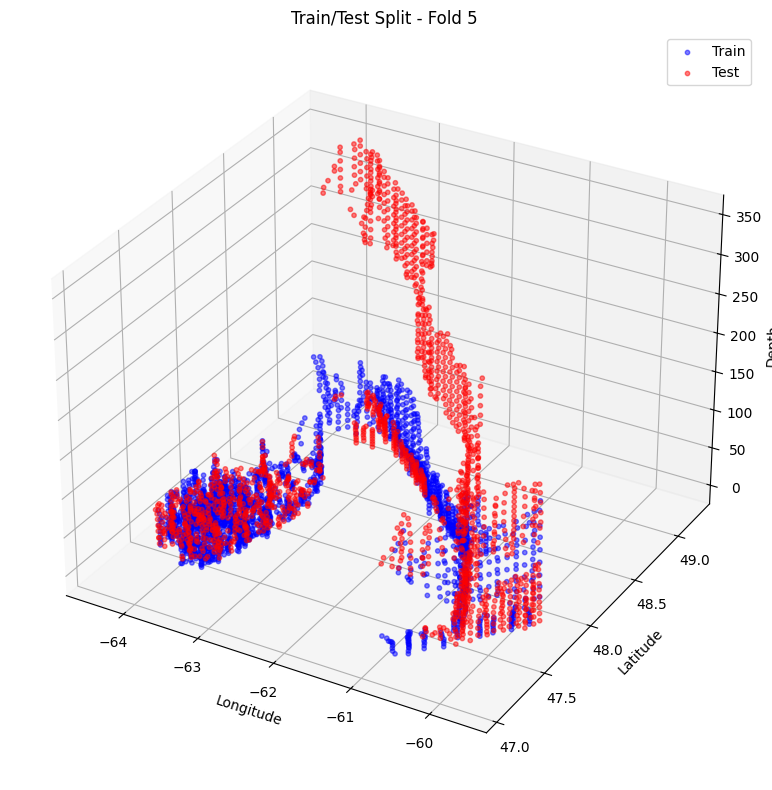

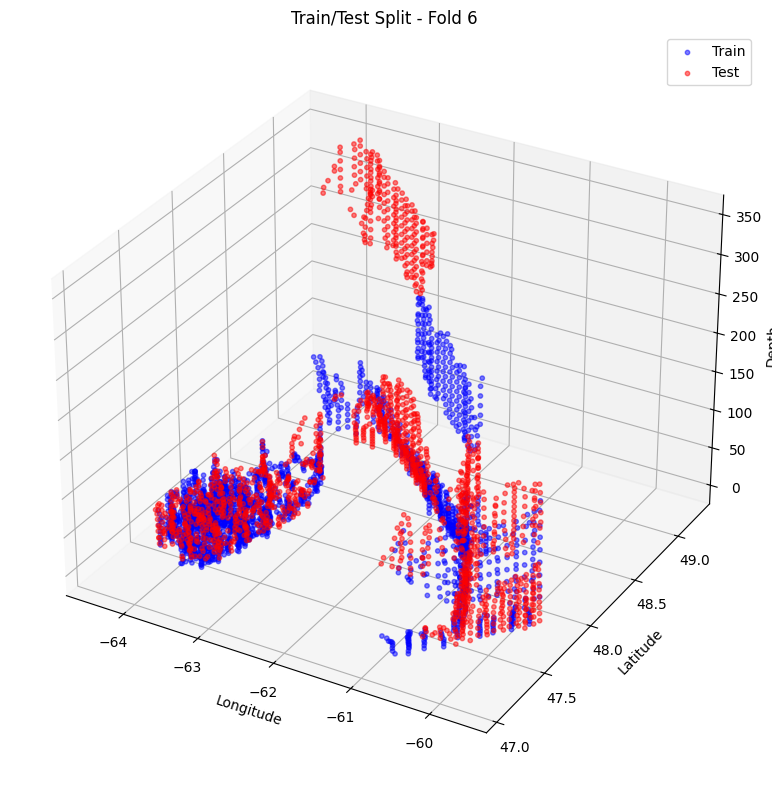

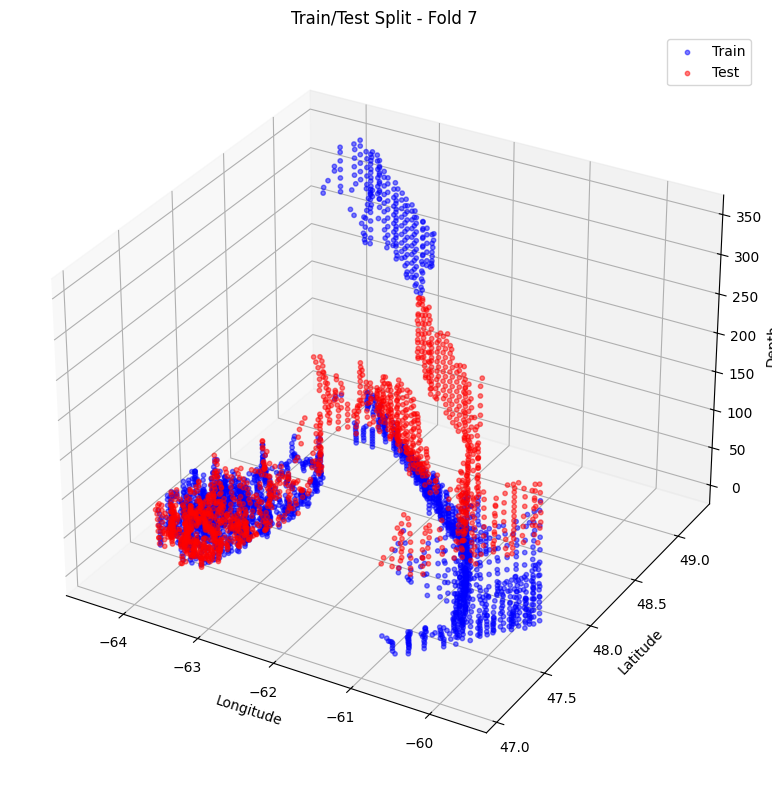

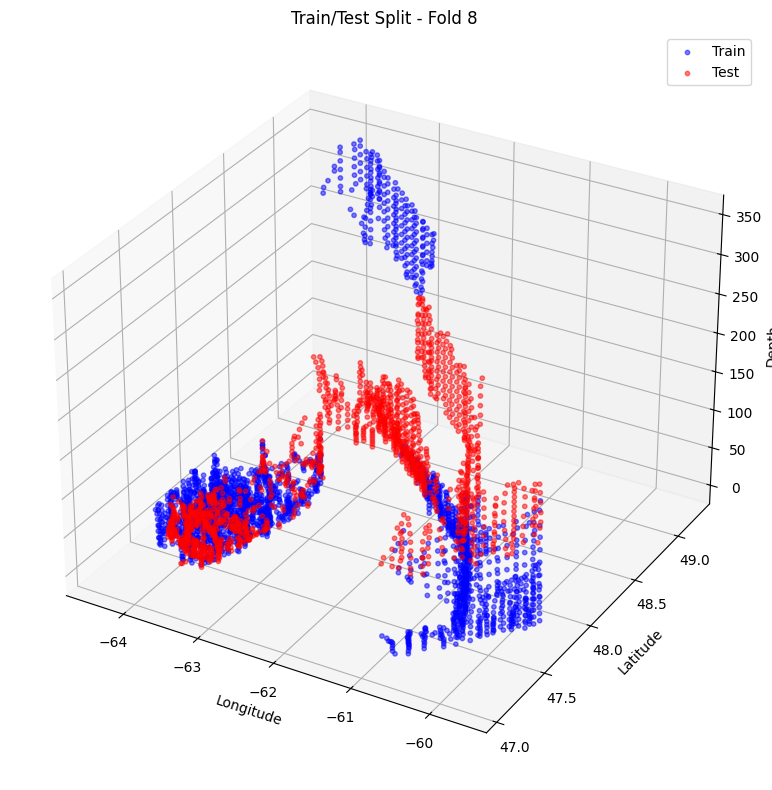

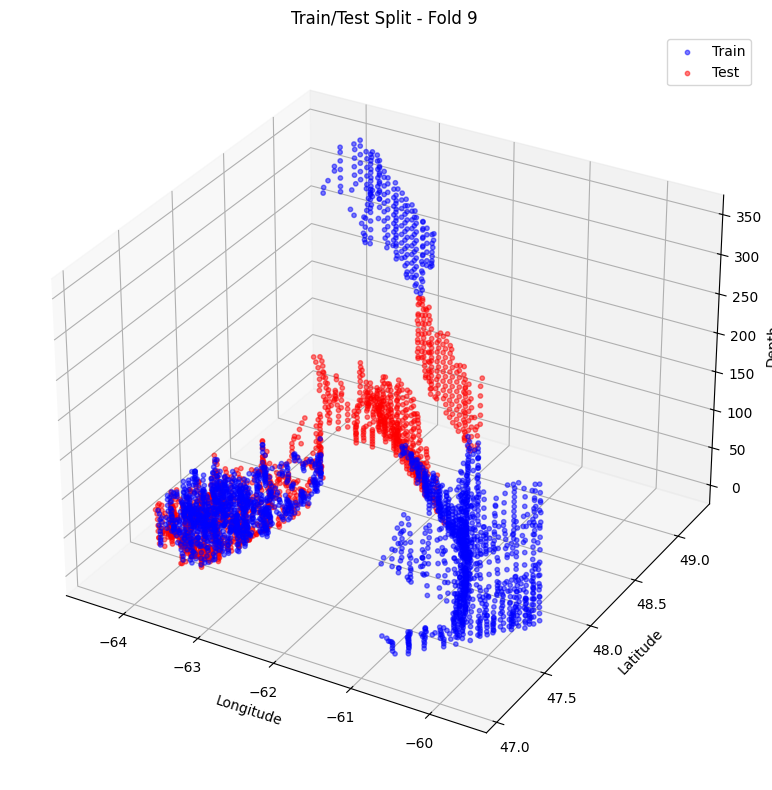

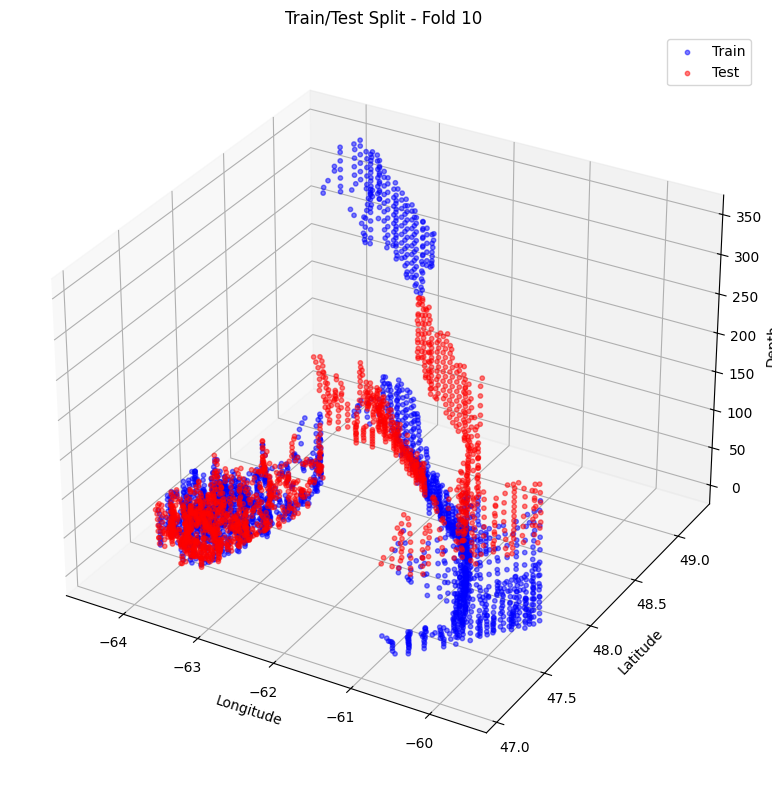

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from itertools import combinations

# Assume datasets is a list of preloaded DataFrames
n_datasets = len(training_datasets)
k = 10 # Total number of folds
train_folds_count = 5

# Step 1: Assign datasets to k folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
dataset_indices = np.arange(n_datasets)

# Organize dataset indices into k folds
folds = [[] for _ in range(k)]
for fold_idx, (_, test_idx) in enumerate(kf.split(dataset_indices)):
    for i in test_idx:
        folds[fold_idx].append(i)

# Step 2: Generate all combinations of 4 folds for training
train_fold_combos = list(combinations(range(k), train_folds_count))
custom_folds = []

# Step 3: Build train/test sets for each combination
for train_combo in train_fold_combos:
    test_combo = [i for i in range(k) if i not in train_combo]

    train_indices = [idx for fold in train_combo for idx in folds[fold]]
    test_indices = [idx for fold in test_combo for idx in folds[fold]]

    train_df = pd.concat([training_datasets[i] for i in train_indices], ignore_index=True)
    test_df = pd.concat([training_datasets[i] for i in test_indices], ignore_index=True)

    custom_folds.append((train_df, test_df))

print(f"Created {len(custom_folds)} custom CV splits ({train_folds_count} train folds, {k - train_folds_count} evaluation folds per split).")

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Choose how many folds to visualize (or visualize all)
n_plot_folds = min(10, len(custom_folds))  # You can change this

for i in range(n_plot_folds):
    train_df, test_df = custom_folds[i]

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot training data (in blue)
    ax.scatter(
        train_df['longitude'], train_df['latitude'], train_df['depth'],
        c='blue', label='Train', alpha=0.5, s=10
    )

    # Plot testing data (in red)
    ax.scatter(
        test_df['longitude'], test_df['latitude'], test_df['depth'],
        c='red', label='Test', alpha=0.5, s=10
    )

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth')
    ax.set_title(f'Train/Test Split - Fold {i+1}')
    ax.legend()
    plt.tight_layout()
    plt.show()


In [29]:
#################
# Linear Models #
#################

from sklearn.model_selection import GridSearchCV

#######################################
# Model 1 Linear regression          #
#######################################

train_df = pd.concat([training_datasets[i] for i in range(len(training_datasets))], ignore_index=True)
test_df = pd.concat([testing_datasets[i] for i in range(len(testing_datasets))], ignore_index=True)

target = 'oxygen'
exclude_cols = [target, 'voxel']

X_train = train_df.drop(columns=exclude_cols)
y_train = train_df[target]
X_test = test_df.drop(columns=exclude_cols)
y_test = test_df[target]

# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions on test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Linear Regression Results:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f} \n \n")


########################
# 2) Elastic net model #
########################


# Expand feature space with interaction terms (without high-degree polynomials)
poly = PolynomialFeatures(degree=5, interaction_only=True, include_bias=False)
X_train_expanded = poly.fit_transform(X_train)
X_test_expanded = poly.transform(X_test)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_expanded)
X_test_scaled = scaler.transform(X_test_expanded)

# Define Elastic Net model
elastic_net = ElasticNet(max_iter=500)  # High max_iter for convergence

# Define Grid Search for alpha (regularization strength) and l1_ratio (balance between Lasso & Ridge)
param_grid = {
    'alpha': np.logspace(-3, 3, 10),  # Regularization strength
    'l1_ratio': [0,0.5,1]   # 0 = Ridge, 1 = Lasso, values in between = Elastic Net
}

# Perform Grid Search with Cross-Validation (5-fold CV)
elastic_cv = GridSearchCV(elastic_net, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
elastic_cv.fit(X_train_scaled, y_train)

# Get the best alpha and l1_ratio
best_alpha = elastic_cv.best_params_['alpha']
best_l1_ratio = elastic_cv.best_params_['l1_ratio']
print(f"Best Elastic penalty: {best_alpha}, Best L1 Ratio: {best_l1_ratio}")

# Train final Elastic Net model with best parameters
best_elastic = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=500)
best_elastic.fit(X_train_scaled, y_train)

# Predictions on test set
y_pred_elastic = best_elastic.predict(X_test_scaled)

# Evaluate the Elastic Net model
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
r2_elastic = r2_score(y_test, y_pred_elastic)

# Print results
print(f"Elastic Net with Interaction Terms:")
print(f"Mean Squared Error: {mse_elastic:.4f}")
print(f"R² Score: {r2_elastic:.4f}")

# Residuals: difference between true values and predicted values
residuals = y_test - y_pred_elastic

# QQ Plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals for Elastic Net Model')
plt.show()

plt.hist(residuals, 100)
plt.title('Histogram of Residuals for Elastic Net Model')
plt.show()




Linear Regression Results:
Mean Squared Error: 792.9293
R² Score: 0.8628 
 



KeyboardInterrupt: 

In [1]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from itertools import product


# Cross validate to find optimal parameter for elastic net

target = 'oxygen'
exclude_cols = [target, 'voxel']

# Define your hyperparameter grid for ElasticNet (only tuning alpha)
param_grid = {
    'alpha': np.logspace(-3, 3, 10),  # penalty term
    'l1_ratio': np.linspace(0, 1, num=10)  # elasticnet mixing parameter, 0.5 means equal mix of Lasso and Ridge
}

# Convert to list of param combinations
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# To store average CV scores for each param combo
results = []

print(f"Total combinations of parameters to try: {len(param_combinations)}")
fold_count = 10
for combo in param_combinations:
    params = dict(zip(param_names, combo))
    mse_scores = []
    r2_scores = []

    for train_df, test_df in custom_folds[:fold_count]:
        X_train = train_df.drop(columns=exclude_cols)
        y_train = train_df[target]
        X_test = test_df.drop(columns=exclude_cols)
        y_test = test_df[target]

        model = ElasticNet(
            alpha=params['alpha'],
            l1_ratio=params['l1_ratio'],
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_scores.append(mse)
        r2_scores.append(r2)
        print(f"R² across current fold: {r2} with length {len(custom_folds[:fold_count])}")

    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    results.append((params, avg_mse, avg_r2))

    print(f"Params: {params}")
    print(f"→ Avg MSE: {avg_mse:.4f} | Avg R²: {avg_r2:.4f}\n")

# Find best param set
best_result = min(results, key=lambda x: x[1])  # smallest MSE
best_params, best_mse, best_r2 = best_result

print("\n===== Best Hyperparameters =====")
print(f"Best Params: {best_params}")
print(f"Avg MSE: {avg_mse:.4f}")
print(f"Avg R²: {avg_r2:.4f}")
print(f"Best RMSE: {np.sqrt(best_mse):.4f}")

# Model using optimal parameter



Total combinations of parameters to try: 100


NameError: name 'custom_folds' is not defined

A Custom CV Fold Generator

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Grab last fold's residuals (or use any index: e.g., 0 for first)
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

# Train a new RF model (or reuse the one from the CV loop)
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Compute residuals
residuals = y_test - y_pred

# 1. Residuals vs. Predictions
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values (Random Forest)")
plt.grid(True)
plt.show()

# 2. Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Histogram of Residuals (Random Forest)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 3. Optional: QQ Plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals (Random Forest)")
plt.grid(True)
plt.show()


ValueError: setting an array element with a sequence.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Replace with the actual column name of your target
target_col = 'oxygen'  # example

mse_rf_scores = []
r2_rf_scores = []

for i, (train_df, test_df) in enumerate(custom_folds):
    X_train = train_df.drop(columns=[target_col,'voxel'])
    y_train = train_df[target_col]
    X_test = test_df.drop(columns=[target_col,'voxel'])
    y_test = test_df[target_col]

    # Define and train Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        max_features='sqrt',
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred = rf_model.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    mse_rf_scores.append(mse)
    r2_rf_scores.append(r2)

    print(f"[RF] Fold {i+1:03d} | MSE: {mse:.4f} | R²: {r2:.4f}")

# Final summary
print("\n===== Random Forest CV Results =====")
print(f"Average MSE: {np.mean(mse_rf_scores):.4f} ± {1.96*np.std(mse_rf_scores):.4f}")
print(f"Average R²: {np.mean(r2_rf_scores):.4f} ± {1.96*np.std(r2_rf_scores):.4f}")


[RF] Fold 001 | MSE: 375.1410 | R²: 0.9459
[RF] Fold 002 | MSE: 307.9654 | R²: 0.9558
[RF] Fold 003 | MSE: 277.9608 | R²: 0.9544
[RF] Fold 004 | MSE: 367.5588 | R²: 0.9122
[RF] Fold 005 | MSE: 375.2610 | R²: 0.9495
[RF] Fold 006 | MSE: 488.8538 | R²: 0.9314
[RF] Fold 007 | MSE: 350.5101 | R²: 0.9451
[RF] Fold 008 | MSE: 213.4672 | R²: 0.9654
[RF] Fold 009 | MSE: 283.6181 | R²: 0.9400
[RF] Fold 010 | MSE: 410.4817 | R²: 0.9441
[RF] Fold 011 | MSE: 569.7313 | R²: 0.9135
[RF] Fold 012 | MSE: 184.0667 | R²: 0.9700
[RF] Fold 013 | MSE: 197.9226 | R²: 0.9570
[RF] Fold 014 | MSE: 299.7422 | R²: 0.9591
[RF] Fold 015 | MSE: 303.9701 | R²: 0.9552
[RF] Fold 016 | MSE: 259.6594 | R²: 0.9058
[RF] Fold 017 | MSE: 238.7339 | R²: 0.9628
[RF] Fold 018 | MSE: 219.2480 | R²: 0.9650
[RF] Fold 019 | MSE: 327.9977 | R²: 0.9276
[RF] Fold 020 | MSE: 277.4157 | R²: 0.9408
[RF] Fold 021 | MSE: 346.6377 | R²: 0.9537
[RF] Fold 022 | MSE: 246.3248 | R²: 0.9591
[RF] Fold 023 | MSE: 233.7396 | R²: 0.9585
[RF] Fold 0

Created 252 custom CV splits (5 train folds, 5 evaluation folds per split).


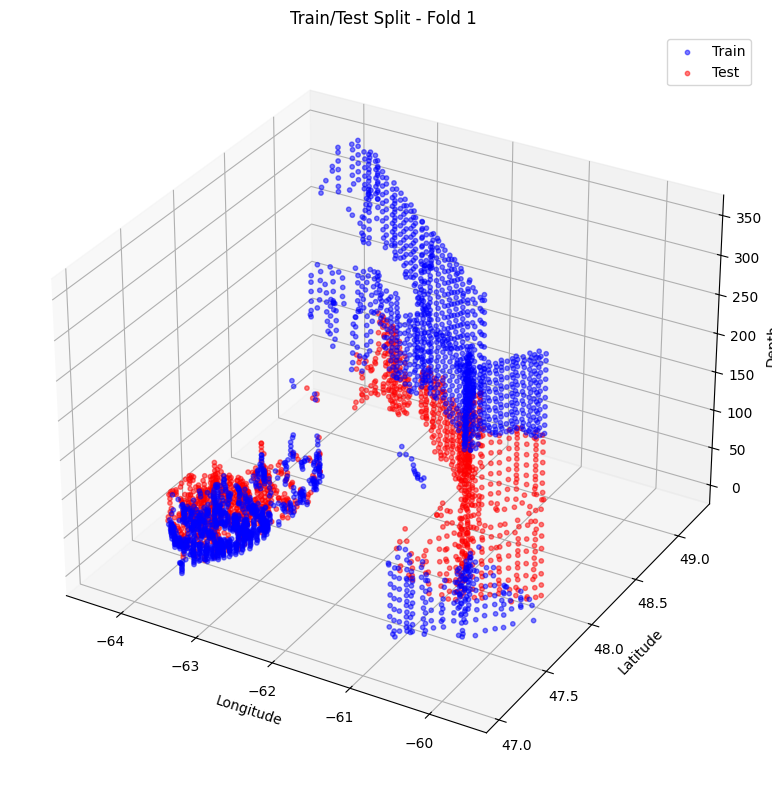

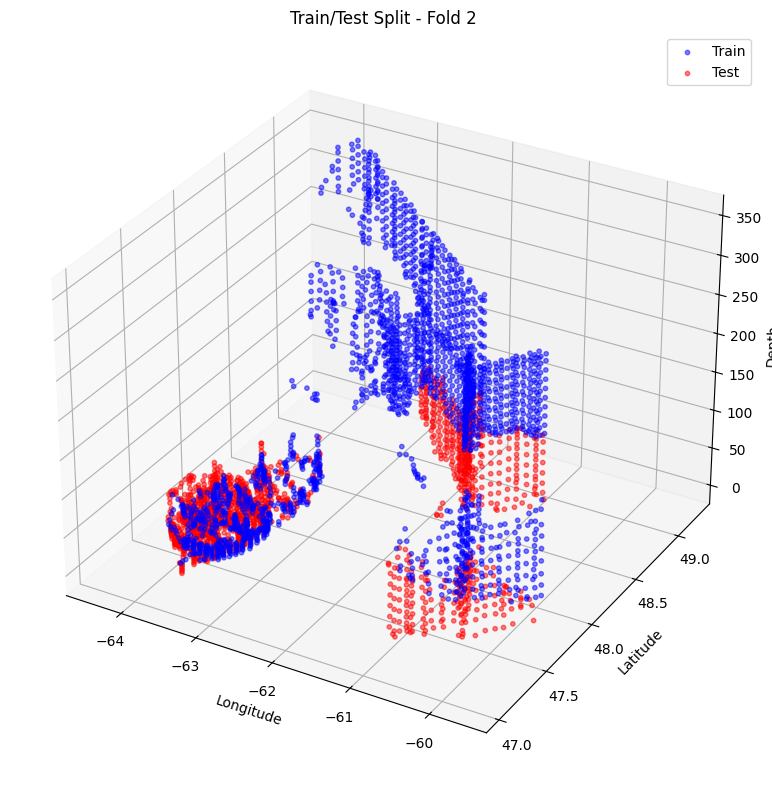

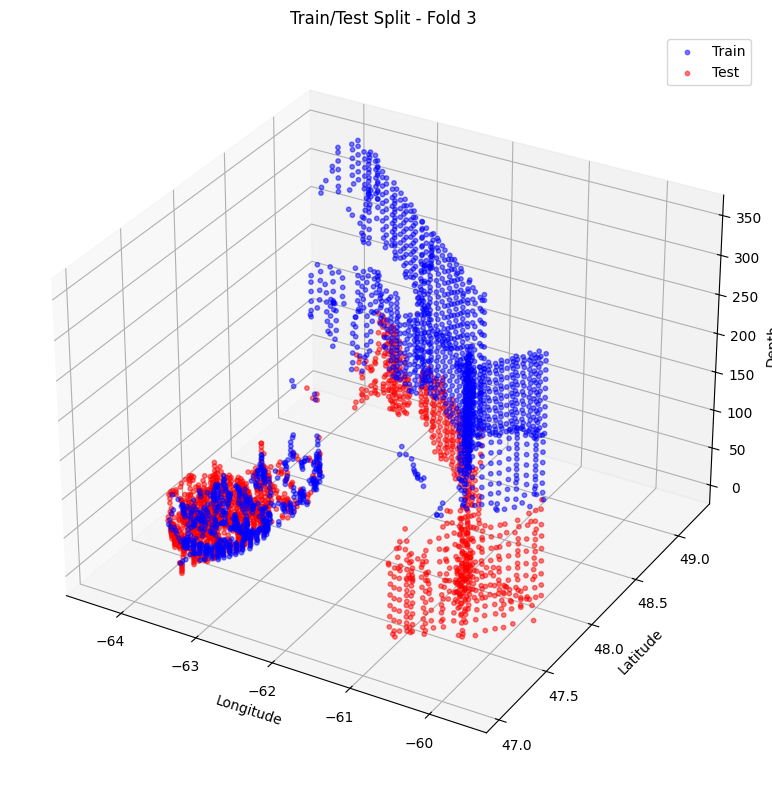

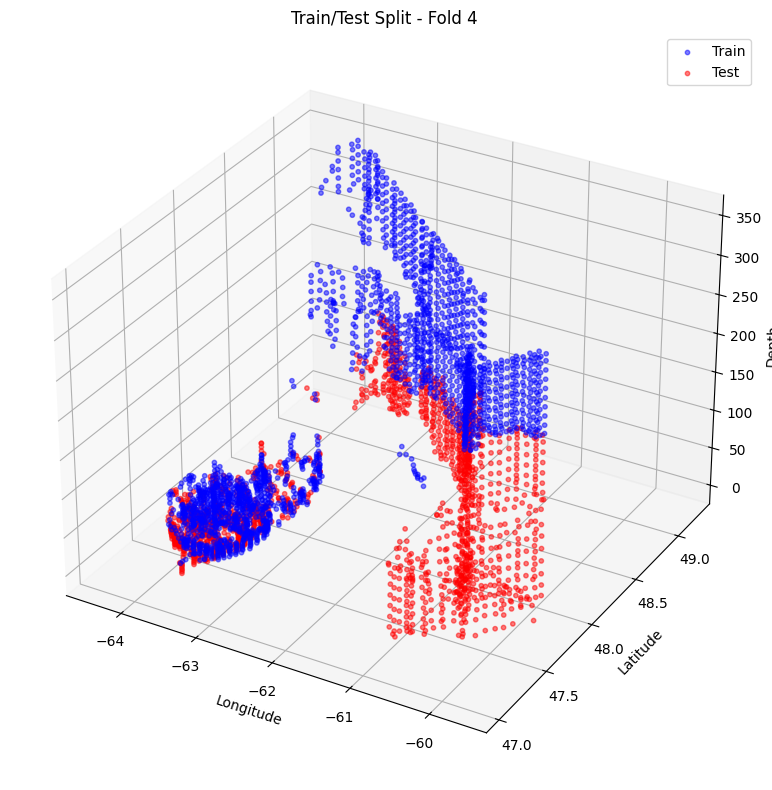

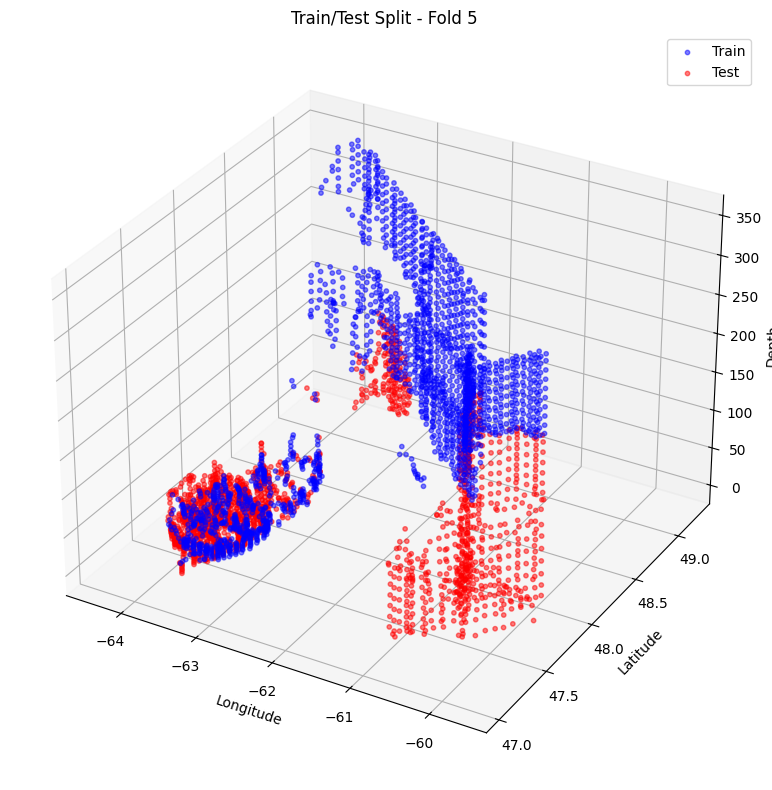

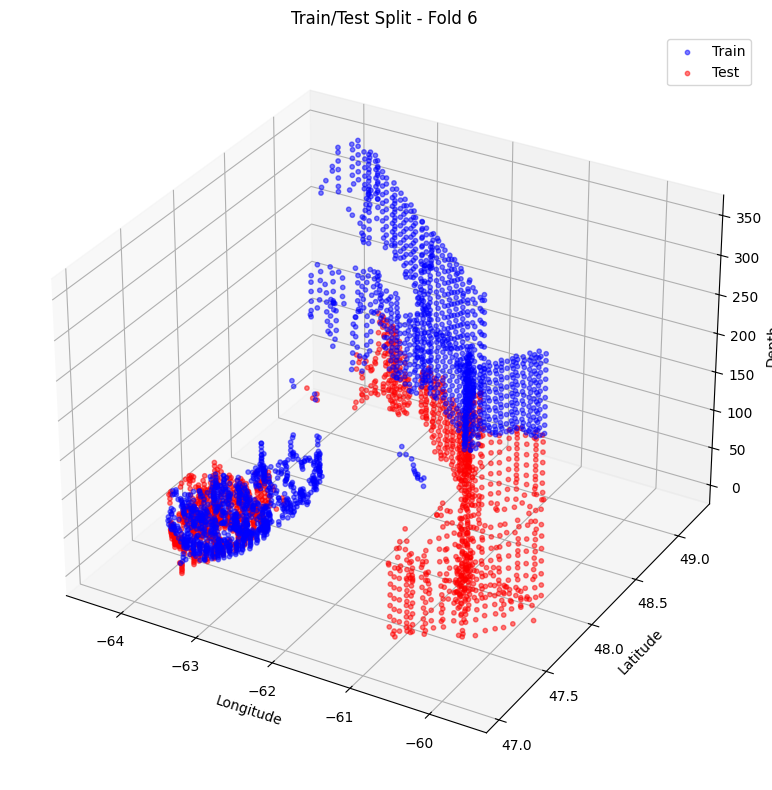

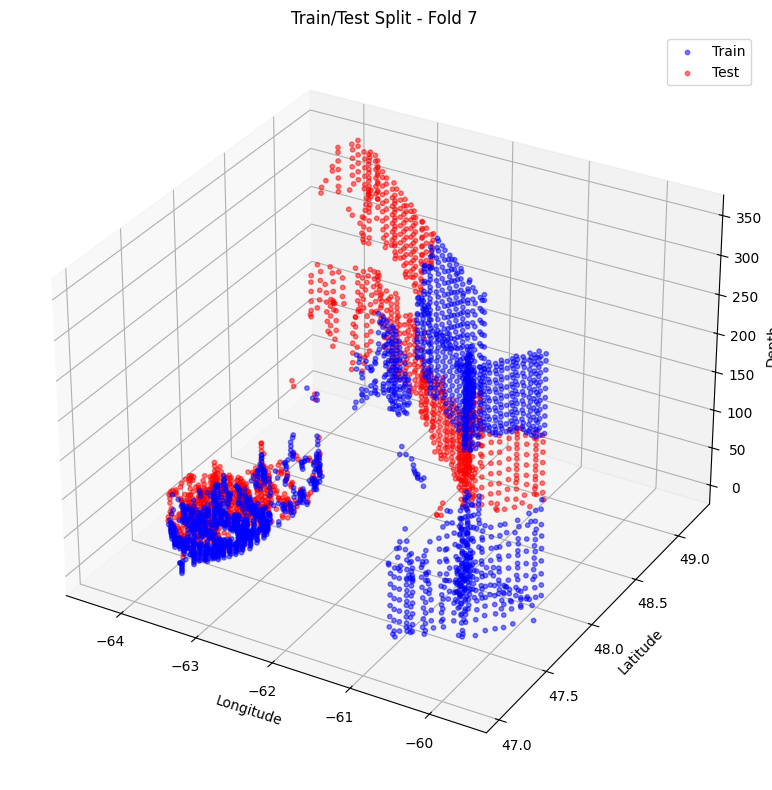

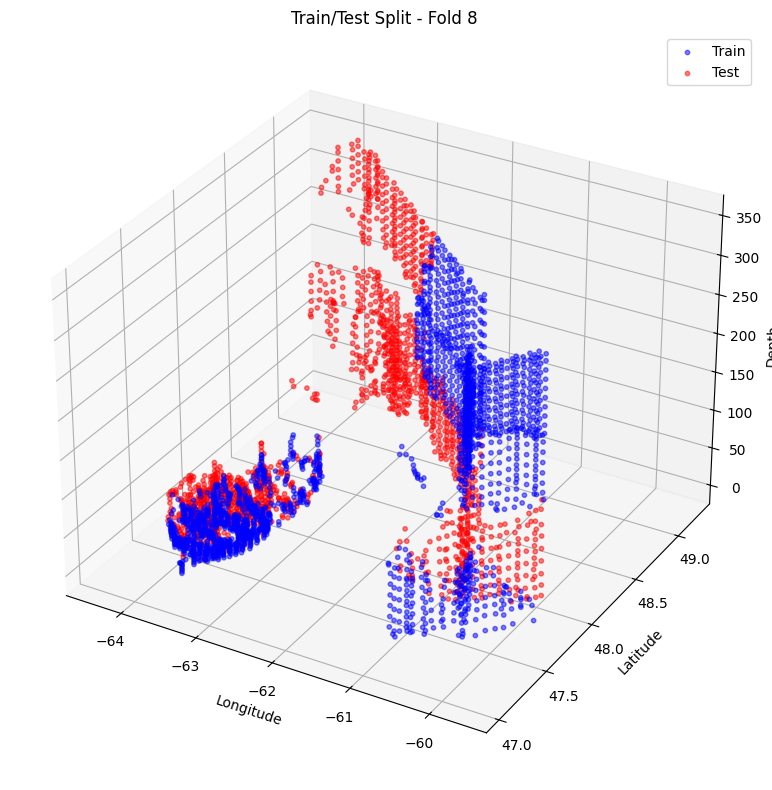

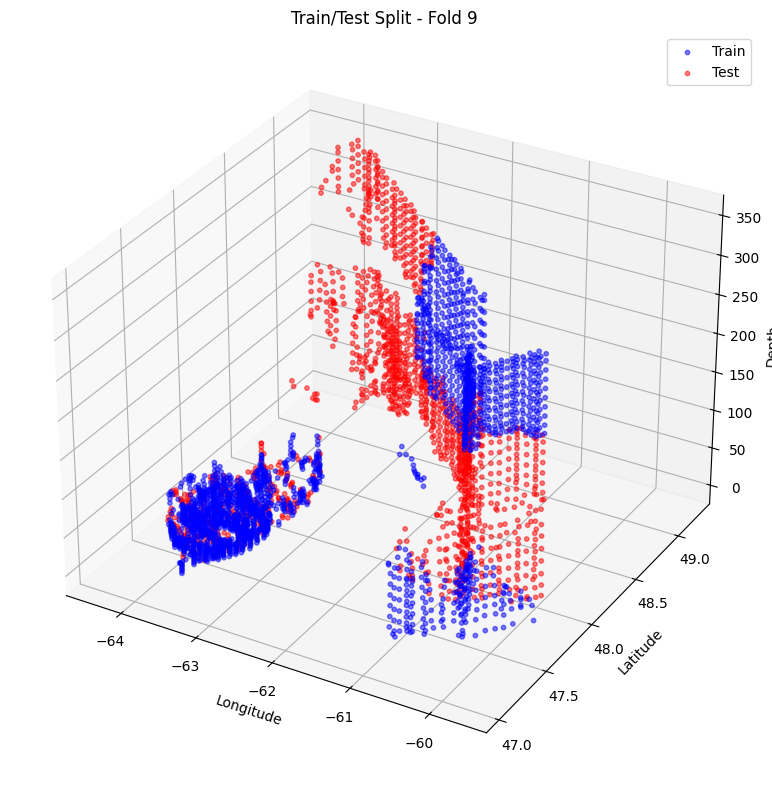

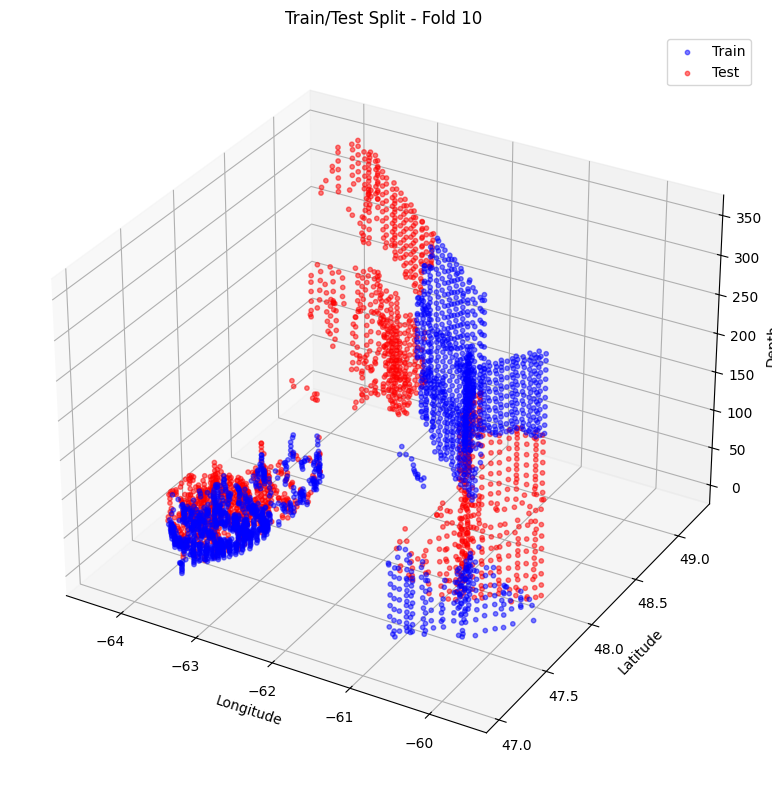

In [14]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product

target = 'oxygen'
exclude_cols = [target, 'voxel']

# Define your hyperparameter grid
param_grid = {
    'n_estimators': [100],
    'learning_rate': np.linspace(0.01, 0.1, 10),
    #'learning_rate': [0.06],
    'max_depth': [8],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

# Convert to list of param combinations
param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

# To store average CV scores for each param combo
results = []

print(f"Total combinations of parameters to try: {len(param_combinations)}")
fold_count = 10
for combo in param_combinations:
    params = dict(zip(param_names, combo))
    mse_scores = []
    r2_scores = []

    for train_df, test_df in custom_folds[:fold_count]:
        X_train = train_df.drop(columns=exclude_cols)
        y_train = train_df[target]
        X_test = test_df.drop(columns=exclude_cols)
        y_test = test_df[target]

        model = xgb.XGBRegressor(
            **params,
            random_state=42,
            verbosity=0
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mse_scores.append(mse)
        r2_scores.append(r2)
        print(f"R² across current fold: {r2} with length {len(custom_folds[:fold_count])}")

    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    results.append((params, avg_mse, avg_r2))

    print(f"Params: {params}")
    print(f"→ Avg MSE: {avg_mse:.4f} | Avg R²: {avg_r2:.4f}\n")

# Find best param set
best_result = min(results, key=lambda x: x[1])  # smallest MSE
best_params, best_mse, best_r2 = best_result

print("\n===== Best Hyperparameters =====")
print(f"Best Params: {best_params}")
print(f"Avg MSE: {best_mse:.4f}")
print(f"Avg R²: {best_r2:.4f}")
print(f"Best RMSE: {np.sqrt(best_mse):.4f}")


Total combinations of parameters to try: 1
R² across current fold: 0.9049820899963379 with length 10
R² across current fold: 0.9001450538635254 with length 10
R² across current fold: 0.568828821182251 with length 10
R² across current fold: 0.858362078666687 with length 10
R² across current fold: 0.6709368228912354 with length 10
R² across current fold: 0.8008167743682861 with length 10
R² across current fold: 0.9185396432876587 with length 10
R² across current fold: 0.9085441827774048 with length 10
R² across current fold: 0.9348932504653931 with length 10
R² across current fold: 0.9453896284103394 with length 10
Params: {'n_estimators': 100, 'learning_rate': 0.06, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.8}
→ Avg MSE: 538.2128 | Avg R²: 0.8411


===== Best Hyperparameters =====
Best Params: {'n_estimators': 100, 'learning_rate': 0.06, 'max_depth': 8, 'subsample': 0.8, 'colsample_bytree': 0.8}
Avg MSE: 538.2128
Avg R²: 0.8411
Best RMSE: 23.1994


<ipython-input-22-b23cdf24c932>:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
<ipython-input-22-b23cdf24c932>:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Learning Rate')


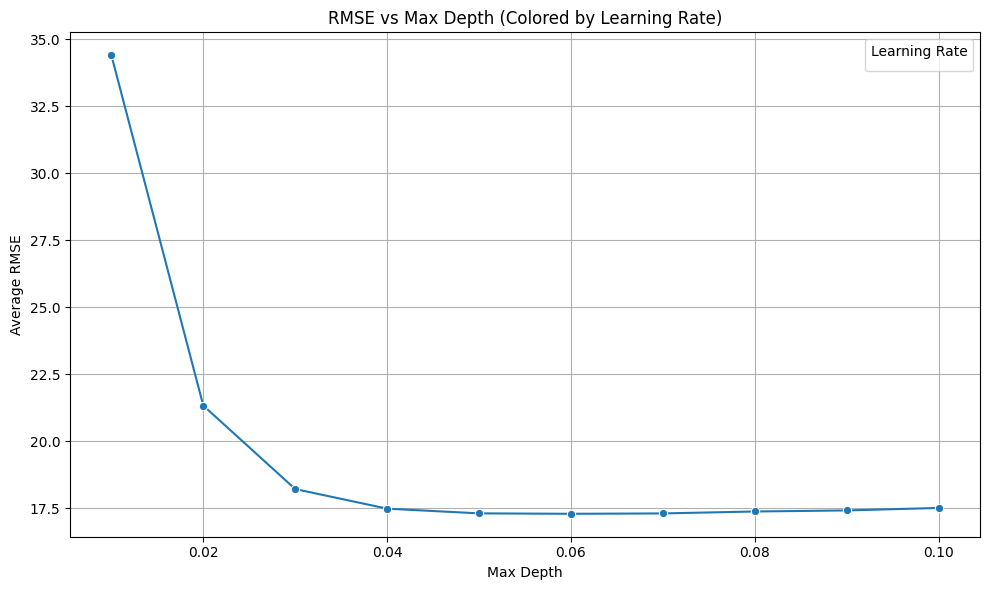

In [ ]:
results_df = pd.DataFrame([
    {
        **params,
        'avg_mse': avg_mse,
        'avg_r2': avg_r2,
        'avg_rmse': np.sqrt(avg_mse)
    }
    for params, avg_mse, avg_r2 in results
])
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df,
    x='learning_rate',
    y='avg_rmse',
    marker='o',
    palette='tab10'
)

plt.title("RMSE vs Max Depth (Colored by Learning Rate)")
plt.xlabel("Max Depth")
plt.ylabel("Average RMSE")
plt.grid(True)
plt.legend(title='Learning Rate')
plt.tight_layout()
plt.show()


In [16]:
# Model evaluation on unseen testing data

train_df = pd.concat([training_datasets[i] for i in range(len(training_datasets))], ignore_index=True)
test_df = pd.concat([testing_datasets[i] for i in range(len(testing_datasets))], ignore_index=True)

target = 'oxygen'
exclude_cols = [target, 'voxel']

X_train = train_df.drop(columns=exclude_cols)
y_train = train_df[target]
X_test = test_df.drop(columns=exclude_cols)
y_test = test_df[target]

model = xgb.XGBRegressor(
    **best_params,
    random_state=42,
    verbosity=0
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse_scores.append(mse)
r2_scores.append(r2)
print(f"R² for optimal parameter {best_params['learning_rate']}: {r2}")

R² for optimal parameter 0.06: 0.9074637293815613


range(0, 20)
          voxel      oxygen  longitude   latitude       depth   salinity  \
0     (0, 2, 2)  291.655426 -63.653671  48.410019   36.695724  31.574543   
1     (0, 2, 3)  290.359070 -63.690769  48.408409   44.567154  31.707136   
2     (0, 2, 4)  284.120605 -63.675640  48.410980   54.964931  31.883253   
3     (0, 2, 5)  272.008087 -63.641220  48.412117   64.403923  32.042461   
4     (0, 2, 6)  253.474899 -63.608250  48.418045   71.334450  32.165012   
...         ...         ...        ...        ...         ...        ...   
2886  (9, 6, 3)  139.838638 -59.659786  47.735996  188.528519  34.395935   
2887  (9, 6, 4)  131.655243 -59.659451  47.736240  201.412491  34.566620   
2888  (9, 6, 5)  124.418259 -59.659477  47.736252  214.328323  34.696156   
2889  (9, 6, 6)  119.125931 -59.660507  47.736431  226.836990  34.776878   
2890  (9, 6, 7)  115.136543 -59.671600  47.737915  234.902954  34.721851   

          density  temperature  
0     1025.438965     1.507956  
1     10